In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [2]:
!rm -rf train test

In [3]:
!mkdir train test
!mkdir train/healthy train/parkinson test/healthy test/parkinson
!cp /kaggle/input/parkinsons-drawings/spiral/training/healthy/* train/healthy
!cp /kaggle/input/parkinsons-drawings/spiral/training/parkinson/* train/parkinson
!cp /kaggle/input/parkinsons-drawings/spiral/testing/healthy/* test/healthy
!cp /kaggle/input/parkinsons-drawings/spiral/testing/parkinson/* test/parkinson
!cp /kaggle/input/parkinsons-drawings/wave/training/healthy/* train/healthy
!cp /kaggle/input/parkinsons-drawings/wave/training/parkinson/* train/parkinson
!cp /kaggle/input/parkinsons-drawings/wave/testing/healthy/* test/healthy
!cp /kaggle/input/parkinsons-drawings/wave/testing/parkinson/* test/parkinson

## Noise Addition

We use this increase the size of the dataset.

In [4]:
def apply_noise(noise_type, image):
    if noise_type == "gauss":
        row, col, ch = image.shape
        mean = 0
        sigma = random.randint(10, 100)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return noisy
    elif noise_type == "s&p":
        row, col, ch = image.shape

        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in (row, col, ch)]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in (row, col, ch)]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type == "speckle":
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)
        noisy = image + image * gauss * 0.2
        return noisy

In [5]:
def motionBlur(img, vertical = True):
    kernel_size = random.randint(20, 35)
    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_h = np.copy(kernel_v)
    kernel_v[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel_v /= kernel_size
    kernel_h /= kernel_size
    return cv2.filter2D(img, -1, kernel_v) if vertical else cv2.filter2D(img, -1, kernel_h)

def pixelate(img):
    height, width = img.shape[:2]
    w, h = (random.randint(100, 150), random.randint(100, 150))
    temp = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)

def normalBlur(img):
    return cv2.blur(img, (random.randint(7, 35), random.randint(7, 35)))

def darken(img):
    return img + random.randint(-50, -1)

def lighten(img):
    return img + random.randint(1, 50)

def gauss(img):
    return apply_noise("gauss", img)

def speckle(img):
    return apply_noise("speckle", img)

In [6]:
for directory in ["train", "test"]:
    for folder in os.listdir(directory):
        for file in os.listdir(f"{directory}/{folder}"):
            if "_" in file: continue
            img = cv2.imread(f"{directory}/{folder}/{file}")
            starter = file.replace('.jpg', '')

            cv2.imwrite(f"{directory}/{folder}/{starter}_motionV.jpg", motionBlur(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_motionH.jpg", motionBlur(img, False))
            cv2.imwrite(f"{directory}/{folder}/{starter}_pixelate.jpg", pixelate(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_normal.jpg", normalBlur(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_dark.jpg", darken(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_light.jpg", lighten(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_gauss.jpg", gauss(img))
            cv2.imwrite(f"{directory}/{folder}/{starter}_speckle.jpg", speckle(img))

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1296 files belonging to 2 classes.
Using 1167 files for training.


2022-11-07 15:56:45.224509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 15:56:45.324737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 15:56:45.325491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 15:56:45.335081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 1296 files belonging to 2 classes.
Using 129 files for validation.


In [8]:
tf.get_logger().setLevel('INFO')

import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

class StoreModelHistory(keras.callbacks.Callback):
    def __init__(self, model_directory):
        super().__init__()
        self.model_directory = model_directory

    def on_epoch_end(self,batch,logs=None):
        if ('lr' not in logs.keys()):
            logs.setdefault('lr',0)
            logs['lr'] = K.get_value(self.model.optimizer.lr)

        if not ('model_history.csv' in os.listdir(self.model_directory)):
            with open(self.model_directory+'model_history.csv','a') as f:
                y = csv.DictWriter(f,logs.keys())
                y.writeheader()

        with open(self.model_directory+'model_history.csv','a') as f:
            y = csv.DictWriter(f,logs.keys())
            y.writerow(logs)

In [9]:
def train(model_name, base_model):
    base_model.trainable = False
    inputs = Input(shape=(256, 256, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    try: os.mkdir(f"logs/{model_name}/")
    except: pass
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[StoreModelHistory(f"logs/{model_name}/")])
    
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    model.save(f"{model_name}-retrained.h5")
    
    return history, model

In [10]:
# Transfer Learning :)

models = (
    ("mobilenet-v3-large", tf.keras.applications.MobileNetV3Large(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet'
    )),
    ("mobilenet-v3-small", tf.keras.applications.MobileNetV3Large(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet'
    )),
    ("efficient-b7", tf.keras.applications.efficientnet.EfficientNetB7(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet'
    ))
)

258088960/258076736 [==============================] - 8s 0us/step


In [11]:
!mkdir logs

Epoch 1/10


2022-11-07 15:57:10.390019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-11-07 15:57:12.062146: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 3/37 [=>............................] - ETA: 3s - loss: 0.7174 - accuracy: 0.5625

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 2s - loss: 0.7465 - accuracy: 0.5000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.7192 - accuracy: 0.5227

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.7075 - accuracy: 0.5402

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.6975 - accuracy: 0.5515

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.6841 - accuracy: 0.5639

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.6806 - accuracy: 0.5671

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6067

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 14s 103ms/step - loss: 0.6533 - accuracy: 0.6067 - val_loss: 0.5298 - val_accuracy: 0.7907
Epoch 2/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.5540 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.5622 - accuracy: 0.7277

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.5412 - accuracy: 0.7386

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.5388 - accuracy: 0.7411

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.5371 - accuracy: 0.7368

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 0s - loss: 0.5370 - accuracy: 0.7357

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


28/37 [=====================>........] - ETA: 0s - loss: 0.5311 - accuracy: 0.7444

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.7543

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 60ms/step - loss: 0.5227 - accuracy: 0.7541 - val_loss: 0.4645 - val_accuracy: 0.7752
Epoch 3/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 2s - loss: 0.4239 - accuracy: 0.8438 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 2s - loss: 0.4620 - accuracy: 0.8000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 1s - loss: 0.4768 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 1s - loss: 0.4676 - accuracy: 0.8047

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 1s - loss: 0.4715 - accuracy: 0.7832

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.4749 - accuracy: 0.7796

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 0s - loss: 0.4825 - accuracy: 0.7695

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.4746 - accuracy: 0.7776

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4716 - accuracy: 0.7873

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 63ms/step - loss: 0.4727 - accuracy: 0.7866 - val_loss: 0.4443 - val_accuracy: 0.8062
Epoch 4/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.4468 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.4413 - accuracy: 0.7902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.4327 - accuracy: 0.8000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.4380 - accuracy: 0.7946

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 1s - loss: 0.4448 - accuracy: 0.7760

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 0s - loss: 0.4454 - accuracy: 0.7784

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.4450 - accuracy: 0.7861

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.4479 - accuracy: 0.7875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4434 - accuracy: 0.7925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 63ms/step - loss: 0.4422 - accuracy: 0.7952 - val_loss: 0.4171 - val_accuracy: 0.8140
Epoch 5/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 14s - loss: 0.3818 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3847 - accuracy: 0.8203

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.4019 - accuracy: 0.8214

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.4057 - accuracy: 0.8156

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.4206 - accuracy: 0.8013

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.4115 - accuracy: 0.8088

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.4272 - accuracy: 0.7962

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.4150 - accuracy: 0.8079

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8038

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 67ms/step - loss: 0.4151 - accuracy: 0.8055 - val_loss: 0.4157 - val_accuracy: 0.7984
Epoch 6/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.4138 - accuracy: 0.8281

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.3812 - accuracy: 0.8482

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.3883 - accuracy: 0.8239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.3968 - accuracy: 0.8167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.3935 - accuracy: 0.8158

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3938 - accuracy: 0.8139

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.3979 - accuracy: 0.8194

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8229

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 61ms/step - loss: 0.3969 - accuracy: 0.8235 - val_loss: 0.3975 - val_accuracy: 0.8062
Epoch 7/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 15s - loss: 0.4268 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3890 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.3693 - accuracy: 0.8393

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.3922 - accuracy: 0.8068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.3933 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.3819 - accuracy: 0.8224

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3951 - accuracy: 0.8166

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.3904 - accuracy: 0.8197

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 60ms/step - loss: 0.3850 - accuracy: 0.8243 - val_loss: 0.3818 - val_accuracy: 0.8140
Epoch 8/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3386 - accuracy: 0.8828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.3491 - accuracy: 0.8616

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.3607 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.3705 - accuracy: 0.8333

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.3674 - accuracy: 0.8322

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3781 - accuracy: 0.8234

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.3732 - accuracy: 0.8310

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8385

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 59ms/step - loss: 0.3694 - accuracy: 0.8398 - val_loss: 0.3608 - val_accuracy: 0.8372
Epoch 9/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 13s - loss: 0.4123 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3683 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 1s - loss: 0.3651 - accuracy: 0.8242

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.3680 - accuracy: 0.8352

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.3662 - accuracy: 0.8417

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.3672 - accuracy: 0.8339

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3662 - accuracy: 0.8315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.3637 - accuracy: 0.8401

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.8420

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 62ms/step - loss: 0.3587 - accuracy: 0.8432 - val_loss: 0.3538 - val_accuracy: 0.8295
Epoch 10/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 1s - loss: 0.3486 - accuracy: 0.8594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.3539 - accuracy: 0.8656

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.3386 - accuracy: 0.8616

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.3482 - accuracy: 0.8553

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3445 - accuracy: 0.8560

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.3484 - accuracy: 0.8519

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.8550

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 60ms/step - loss: 0.3484 - accuracy: 0.8535 - val_loss: 0.3400 - val_accuracy: 0.8450


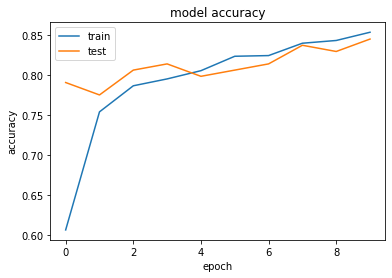

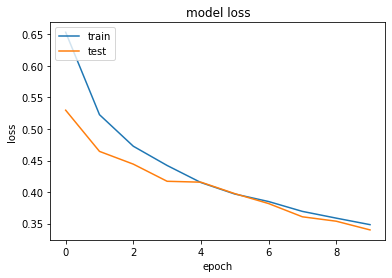

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.7206 - accuracy: 0.5312

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 2s - loss: 0.7522 - accuracy: 0.5000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 1s - loss: 0.7470 - accuracy: 0.4965

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.7394 - accuracy: 0.5156

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.7215 - accuracy: 0.5294

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 0s - loss: 0.7031 - accuracy: 0.5625

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.6979 - accuracy: 0.5697

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.6875 - accuracy: 0.5802

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.5955

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 7s 97ms/step - loss: 0.6709 - accuracy: 0.5973 - val_loss: 0.5414 - val_accuracy: 0.7597
Epoch 2/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 2s - loss: 0.5640 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.5491 - accuracy: 0.7366

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.5567 - accuracy: 0.7188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.5538 - accuracy: 0.7165

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.5613 - accuracy: 0.7151

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 0s - loss: 0.5502 - accuracy: 0.7273

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.5456 - accuracy: 0.7308

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.5385 - accuracy: 0.7417

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7465

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 62ms/step - loss: 0.5352 - accuracy: 0.7464 - val_loss: 0.4593 - val_accuracy: 0.8295
Epoch 3/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.4896 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.4850 - accuracy: 0.7946

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.4881 - accuracy: 0.7869

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.4844 - accuracy: 0.7857

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 0s - loss: 0.4914 - accuracy: 0.7763

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 0s - loss: 0.4938 - accuracy: 0.7708

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.4991 - accuracy: 0.7644

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4815 - accuracy: 0.7804

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 58ms/step - loss: 0.4824 - accuracy: 0.7798 - val_loss: 0.4285 - val_accuracy: 0.8217
Epoch 4/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.4549 - accuracy: 0.7734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.4362 - accuracy: 0.7991

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.4418 - accuracy: 0.7926

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.4518 - accuracy: 0.7854

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.4460 - accuracy: 0.7895

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.4585 - accuracy: 0.7731

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.4546 - accuracy: 0.7789

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4487 - accuracy: 0.7899

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 67ms/step - loss: 0.4473 - accuracy: 0.7918 - val_loss: 0.4060 - val_accuracy: 0.8217
Epoch 5/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 14s - loss: 0.4456 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.4384 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.4297 - accuracy: 0.7946

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 1s - loss: 0.4222 - accuracy: 0.8011

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 1s - loss: 0.4315 - accuracy: 0.7792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


19/37 [==============>...............] - ETA: 1s - loss: 0.4330 - accuracy: 0.7829

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.4286 - accuracy: 0.7921

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.4281 - accuracy: 0.7951

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


32/37 [========================>.....] - ETA: 0s - loss: 0.4282 - accuracy: 0.8008

Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4238 - accuracy: 0.8047

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 61ms/step - loss: 0.4220 - accuracy: 0.8072 - val_loss: 0.3805 - val_accuracy: 0.8605
Epoch 6/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3648 - accuracy: 0.8516

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 1s - loss: 0.3779 - accuracy: 0.8259

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.3801 - accuracy: 0.8250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.4053 - accuracy: 0.8036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.4069 - accuracy: 0.8015

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 0s - loss: 0.4041 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 0s - loss: 0.4000 - accuracy: 0.8188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.4033 - accuracy: 0.8188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8212

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 61ms/step - loss: 0.4036 - accuracy: 0.8201 - val_loss: 0.3921 - val_accuracy: 0.8295
Epoch 7/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 2s - loss: 0.4460 - accuracy: 0.7812 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 1s - loss: 0.3900 - accuracy: 0.8229

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 1s - loss: 0.3765 - accuracy: 0.8375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 1s - loss: 0.3874 - accuracy: 0.8237

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 1s - loss: 0.3920 - accuracy: 0.8143

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.4003 - accuracy: 0.8071

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


27/37 [====================>.........] - ETA: 0s - loss: 0.3987 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.3971 - accuracy: 0.8115

Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 60ms/step - loss: 0.3913 - accuracy: 0.8243 - val_loss: 0.3759 - val_accuracy: 0.8295
Epoch 8/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 13s - loss: 0.3216 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 1s - loss: 0.3686 - accuracy: 0.8375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 1s - loss: 0.3749 - accuracy: 0.8633

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 1s - loss: 0.3664 - accuracy: 0.8542

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 1s - loss: 0.3908 - accuracy: 0.8223

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 0s - loss: 0.3750 - accuracy: 0.8344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 0s - loss: 0.3809 - accuracy: 0.8356

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


28/37 [=====================>........] - ETA: 0s - loss: 0.3798 - accuracy: 0.8348

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8429

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 59ms/step - loss: 0.3764 - accuracy: 0.8432 - val_loss: 0.3737 - val_accuracy: 0.8217
Epoch 9/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 14s - loss: 0.4519 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 2s - loss: 0.3534 - accuracy: 0.8516

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 1s - loss: 0.3695 - accuracy: 0.8359

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 1s - loss: 0.3660 - accuracy: 0.8411

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 1s - loss: 0.3699 - accuracy: 0.8340

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 0s - loss: 0.3697 - accuracy: 0.8344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 0s - loss: 0.3790 - accuracy: 0.8229

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


28/37 [=====================>........] - ETA: 0s - loss: 0.3803 - accuracy: 0.8248

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3705 - accuracy: 0.8307

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 61ms/step - loss: 0.3699 - accuracy: 0.8312 - val_loss: 0.3496 - val_accuracy: 0.8527
Epoch 10/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 2s - loss: 0.3693 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 2s - loss: 0.3384 - accuracy: 0.8594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 2s - loss: 0.3488 - accuracy: 0.8516

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


10/37 [=======>......................] - ETA: 2s - loss: 0.3406 - accuracy: 0.8594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 2s - loss: 0.3376 - accuracy: 0.8558

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 2s - loss: 0.3473 - accuracy: 0.8396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 1s - loss: 0.3529 - accuracy: 0.8420

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 1s - loss: 0.3611 - accuracy: 0.8395

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


26/37 [====================>.........] - ETA: 0s - loss: 0.3668 - accuracy: 0.8305

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


30/37 [=======================>......] - ETA: 0s - loss: 0.3621 - accuracy: 0.8344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


36/37 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 3s 79ms/step - loss: 0.3579 - accuracy: 0.8432 - val_loss: 0.3575 - val_accuracy: 0.8295


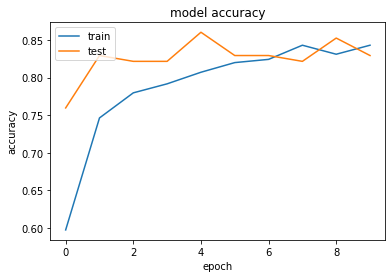

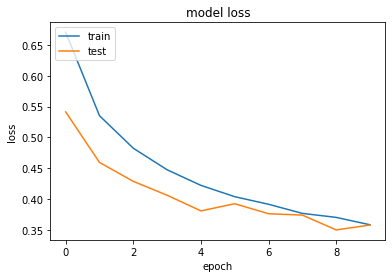

Epoch 1/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 10:24 - loss: 0.6813 - accuracy: 0.6250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.5938  

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 11s - loss: 0.6808 - accuracy: 0.5833

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5781

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.6910 - accuracy: 0.5469 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.6835 - accuracy: 0.5714

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.6782 - accuracy: 0.5820

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.6745 - accuracy: 0.5868

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.6719 - accuracy: 0.5938

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.6657 - accuracy: 0.6108

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.6653 - accuracy: 0.6094

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6130

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.6643 - accuracy: 0.6049

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.6656 - accuracy: 0.6000

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.6626 - accuracy: 0.6055

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 5s - loss: 0.6609 - accuracy: 0.6048

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.6600 - accuracy: 0.6024

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.6551 - accuracy: 0.6118

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.6571 - accuracy: 0.6062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.6544 - accuracy: 0.6101

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.6493 - accuracy: 0.6136

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.6484 - accuracy: 0.6168

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.6475 - accuracy: 0.6185

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.6456 - accuracy: 0.6212

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.6441 - accuracy: 0.6262

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.6495

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 34s 457ms/step - loss: 0.6297 - accuracy: 0.6495 - val_loss: 0.6102 - val_accuracy: 0.6822
Epoch 2/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 25s - loss: 0.6046 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.5632 - accuracy: 0.8281

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.5664 - accuracy: 0.7917

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.5725 - accuracy: 0.7656

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 9s - loss: 0.5735 - accuracy: 0.7500 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.5705 - accuracy: 0.7448

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 8s - loss: 0.5690 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.5703 - accuracy: 0.7578

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.5656 - accuracy: 0.7604

Cleanup called...


10/37 [=======>......................] - ETA: 7s - loss: 0.5629 - accuracy: 0.7594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.5700 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.5690 - accuracy: 0.7526

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.5716 - accuracy: 0.7476

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.5662 - accuracy: 0.7522

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.5675 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.5638 - accuracy: 0.7539

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 5s - loss: 0.5614 - accuracy: 0.7537

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.5611 - accuracy: 0.7552

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.5634 - accuracy: 0.7549

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.5629 - accuracy: 0.7531

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.5632 - accuracy: 0.7530

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.5607 - accuracy: 0.7557

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.5605 - accuracy: 0.7541

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.5610 - accuracy: 0.7539

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.5604 - accuracy: 0.7563

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.5621 - accuracy: 0.7536

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.7464

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 323ms/step - loss: 0.5546 - accuracy: 0.7464 - val_loss: 0.5535 - val_accuracy: 0.6977
Epoch 3/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 22s - loss: 0.4563 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 10s - loss: 0.4911 - accuracy: 0.7969

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.5298 - accuracy: 0.7604

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.5363 - accuracy: 0.7422

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 9s - loss: 0.5325 - accuracy: 0.7375 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.5325 - accuracy: 0.7396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.5332 - accuracy: 0.7545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.5312 - accuracy: 0.7617

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.5381 - accuracy: 0.7535

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.5249 - accuracy: 0.7688

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.5194 - accuracy: 0.7727

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.5142 - accuracy: 0.7760

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.5168 - accuracy: 0.7668

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.5174 - accuracy: 0.7656

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.5176 - accuracy: 0.7604

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.5152 - accuracy: 0.7637

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 5s - loss: 0.5147 - accuracy: 0.7629

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.5174 - accuracy: 0.7569

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.5167 - accuracy: 0.7599

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.5182 - accuracy: 0.7609

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.5198 - accuracy: 0.7560

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.5186 - accuracy: 0.7599

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.5200 - accuracy: 0.7595

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.5238 - accuracy: 0.7539

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.5253 - accuracy: 0.7487

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.5250 - accuracy: 0.7488

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.7618

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 324ms/step - loss: 0.5184 - accuracy: 0.7618 - val_loss: 0.5223 - val_accuracy: 0.7364
Epoch 4/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 24s - loss: 0.4867 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.4893 - accuracy: 0.7344

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.4813 - accuracy: 0.7396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.5158 - accuracy: 0.7188

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 10s - loss: 0.4982 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4855 - accuracy: 0.7604 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4921 - accuracy: 0.7545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.5039 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.5006 - accuracy: 0.7465

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.4970 - accuracy: 0.7531

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4885 - accuracy: 0.7614

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4855 - accuracy: 0.7630

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4791 - accuracy: 0.7716

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.4876 - accuracy: 0.7589

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4859 - accuracy: 0.7625

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4934 - accuracy: 0.7578

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 6s - loss: 0.4914 - accuracy: 0.7592

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4873 - accuracy: 0.7691

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4910 - accuracy: 0.7648

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4907 - accuracy: 0.7688

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4930 - accuracy: 0.7679

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4920 - accuracy: 0.7699

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4932 - accuracy: 0.7690

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4953 - accuracy: 0.7682

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4958 - accuracy: 0.7663

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4952 - accuracy: 0.7656

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7823

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 328ms/step - loss: 0.4920 - accuracy: 0.7823 - val_loss: 0.5018 - val_accuracy: 0.7752
Epoch 5/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 23s - loss: 0.5646 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.5135 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 11s - loss: 0.4918 - accuracy: 0.7604

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.4934 - accuracy: 0.7578

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 10s - loss: 0.4853 - accuracy: 0.7688

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4778 - accuracy: 0.7708 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4894 - accuracy: 0.7545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4988 - accuracy: 0.7422

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4921 - accuracy: 0.7431

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.5062 - accuracy: 0.7406

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 8s - loss: 0.5029 - accuracy: 0.7415

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.5015 - accuracy: 0.7396

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4970 - accuracy: 0.7452

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 7s - loss: 0.4962 - accuracy: 0.7522

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4916 - accuracy: 0.7500

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4915 - accuracy: 0.7480

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 6s - loss: 0.4896 - accuracy: 0.7518

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4914 - accuracy: 0.7500

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4879 - accuracy: 0.7566

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4828 - accuracy: 0.7625

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4791 - accuracy: 0.7664

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4762 - accuracy: 0.7727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4787 - accuracy: 0.7704

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4748 - accuracy: 0.7773

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4749 - accuracy: 0.7800

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4771 - accuracy: 0.7764

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7918

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 13s 331ms/step - loss: 0.4722 - accuracy: 0.7918 - val_loss: 0.4900 - val_accuracy: 0.7597
Epoch 6/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 25s - loss: 0.4326 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 10s - loss: 0.5207 - accuracy: 0.7031

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.5272 - accuracy: 0.7396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.5026 - accuracy: 0.7656

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 9s - loss: 0.4790 - accuracy: 0.7812 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4694 - accuracy: 0.7969

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 8s - loss: 0.4731 - accuracy: 0.7902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4882 - accuracy: 0.7773

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4833 - accuracy: 0.7778

Cleanup called...


10/37 [=======>......................] - ETA: 7s - loss: 0.4773 - accuracy: 0.7844

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4765 - accuracy: 0.7841

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4899 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4847 - accuracy: 0.7885

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.4834 - accuracy: 0.7946

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4828 - accuracy: 0.7958

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4817 - accuracy: 0.7930

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 5s - loss: 0.4790 - accuracy: 0.7996

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4834 - accuracy: 0.7969

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4844 - accuracy: 0.7977

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4812 - accuracy: 0.7984

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4779 - accuracy: 0.7991

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4770 - accuracy: 0.7983

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4724 - accuracy: 0.8043

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4692 - accuracy: 0.8073

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4700 - accuracy: 0.8075

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4730 - accuracy: 0.8005

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.7978

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 325ms/step - loss: 0.4664 - accuracy: 0.7978 - val_loss: 0.4611 - val_accuracy: 0.7597
Epoch 7/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 24s - loss: 0.4857 - accuracy: 0.6562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.4862 - accuracy: 0.7188

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 11s - loss: 0.4615 - accuracy: 0.7396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.4694 - accuracy: 0.7266

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 10s - loss: 0.4613 - accuracy: 0.7437

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4571 - accuracy: 0.7604 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4563 - accuracy: 0.7634

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4576 - accuracy: 0.7617

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4546 - accuracy: 0.7604

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.4496 - accuracy: 0.7594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4532 - accuracy: 0.7614

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4529 - accuracy: 0.7656

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4470 - accuracy: 0.7716

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.4485 - accuracy: 0.7701

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4520 - accuracy: 0.7667

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4467 - accuracy: 0.7734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 5s - loss: 0.4400 - accuracy: 0.7831

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4432 - accuracy: 0.7778

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4422 - accuracy: 0.7829

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4422 - accuracy: 0.7844

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4443 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4468 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4503 - accuracy: 0.7799

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4524 - accuracy: 0.7799

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4517 - accuracy: 0.7800

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4482 - accuracy: 0.7861

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.7918

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 325ms/step - loss: 0.4474 - accuracy: 0.7918 - val_loss: 0.4719 - val_accuracy: 0.7597
Epoch 8/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 23s - loss: 0.4505 - accuracy: 0.7188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.4290 - accuracy: 0.7344

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.4371 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.4459 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 9s - loss: 0.4429 - accuracy: 0.7937 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4644 - accuracy: 0.7708

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4551 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4586 - accuracy: 0.7695

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4688 - accuracy: 0.7604

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.4669 - accuracy: 0.7656

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4648 - accuracy: 0.7642

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4587 - accuracy: 0.7682

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4577 - accuracy: 0.7692

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.4537 - accuracy: 0.7701

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4575 - accuracy: 0.7667

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4535 - accuracy: 0.7734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 6s - loss: 0.4560 - accuracy: 0.7721

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4596 - accuracy: 0.7691

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4581 - accuracy: 0.7681

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4524 - accuracy: 0.7750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4551 - accuracy: 0.7708

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4529 - accuracy: 0.7727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4550 - accuracy: 0.7758

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4572 - accuracy: 0.7747

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4533 - accuracy: 0.7825

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4553 - accuracy: 0.7825

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.7926

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 12s 328ms/step - loss: 0.4435 - accuracy: 0.7926 - val_loss: 0.4461 - val_accuracy: 0.8140
Epoch 9/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 23s - loss: 0.3883 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.4552 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 11s - loss: 0.4570 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.4414 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 10s - loss: 0.4382 - accuracy: 0.7937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.4447 - accuracy: 0.7917 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4495 - accuracy: 0.7857

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4423 - accuracy: 0.7891

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4337 - accuracy: 0.8056

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.4278 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4195 - accuracy: 0.8210

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4163 - accuracy: 0.8229

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4161 - accuracy: 0.8173

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 7s - loss: 0.4173 - accuracy: 0.8125

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4159 - accuracy: 0.8146

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4198 - accuracy: 0.8105

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 6s - loss: 0.4222 - accuracy: 0.8070

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4226 - accuracy: 0.8056

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4240 - accuracy: 0.8076

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4262 - accuracy: 0.8062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4232 - accuracy: 0.8095

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4244 - accuracy: 0.8068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4290 - accuracy: 0.8057

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4280 - accuracy: 0.8086

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4323 - accuracy: 0.8050

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4315 - accuracy: 0.8053

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8106

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 13s 331ms/step - loss: 0.4286 - accuracy: 0.8106 - val_loss: 0.4433 - val_accuracy: 0.7829
Epoch 10/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/37 [..............................] - ETA: 26s - loss: 0.4091 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 2/37 [>.............................] - ETA: 11s - loss: 0.4166 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


 3/37 [=>............................] - ETA: 10s - loss: 0.3862 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/37 [==>...........................] - ETA: 10s - loss: 0.3945 - accuracy: 0.8047

Cleanup called...
Cleanup called...
Cleanup called...


 5/37 [===>..........................] - ETA: 9s - loss: 0.3881 - accuracy: 0.8188 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 6/37 [===>..........................] - ETA: 9s - loss: 0.3962 - accuracy: 0.8073

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/37 [====>.........................] - ETA: 9s - loss: 0.4249 - accuracy: 0.7902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 8/37 [=====>........................] - ETA: 8s - loss: 0.4198 - accuracy: 0.8008

Cleanup called...
Cleanup called...
Cleanup called...


 9/37 [======>.......................] - ETA: 8s - loss: 0.4348 - accuracy: 0.7882

Cleanup called...


10/37 [=======>......................] - ETA: 8s - loss: 0.4286 - accuracy: 0.7937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/37 [=======>......................] - ETA: 7s - loss: 0.4321 - accuracy: 0.7983

Cleanup called...
Cleanup called...
Cleanup called...


12/37 [========>.....................] - ETA: 7s - loss: 0.4199 - accuracy: 0.8125

Cleanup called...
Cleanup called...
Cleanup called...


13/37 [=========>....................] - ETA: 7s - loss: 0.4170 - accuracy: 0.8149

Cleanup called...
Cleanup called...


14/37 [==========>...................] - ETA: 6s - loss: 0.4118 - accuracy: 0.8214

Cleanup called...
Cleanup called...


15/37 [===========>..................] - ETA: 6s - loss: 0.4068 - accuracy: 0.8292

Cleanup called...
Cleanup called...
Cleanup called...


16/37 [===========>..................] - ETA: 6s - loss: 0.4133 - accuracy: 0.8184

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


17/37 [============>.................] - ETA: 6s - loss: 0.4135 - accuracy: 0.8199

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/37 [=============>................] - ETA: 5s - loss: 0.4101 - accuracy: 0.8194

Cleanup called...


19/37 [==============>...............] - ETA: 5s - loss: 0.4086 - accuracy: 0.8207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/37 [===============>..............] - ETA: 5s - loss: 0.4073 - accuracy: 0.8234

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


21/37 [================>.............] - ETA: 4s - loss: 0.4104 - accuracy: 0.8214

Cleanup called...
Cleanup called...
Cleanup called...


22/37 [================>.............] - ETA: 4s - loss: 0.4145 - accuracy: 0.8210

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/37 [=================>............] - ETA: 4s - loss: 0.4157 - accuracy: 0.8247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


24/37 [==================>...........] - ETA: 3s - loss: 0.4141 - accuracy: 0.8268

Cleanup called...
Cleanup called...
Cleanup called...


25/37 [===================>..........] - ETA: 3s - loss: 0.4146 - accuracy: 0.8275

Cleanup called...


26/37 [====================>.........] - ETA: 3s - loss: 0.4130 - accuracy: 0.8281

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8226

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


37/37 [==============================] - 13s 327ms/step - loss: 0.4178 - accuracy: 0.8226 - val_loss: 0.4437 - val_accuracy: 0.7752


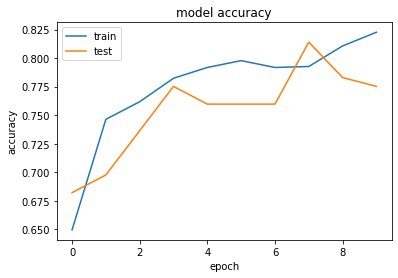

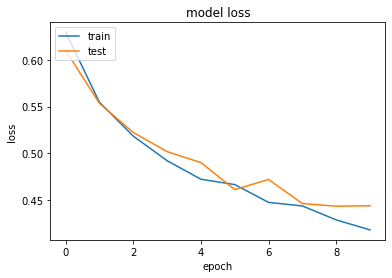

In [12]:
for model_name, base_model in models:
    train(model_name, base_model)

In [13]:
!ls logs/*

logs/efficient-b7:
model_history.csv

logs/mobilenet-v3-large:
model_history.csv

logs/mobilenet-v3-small:
model_history.csv
